# Імпорт Бібліотек Йоооооу

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")


# Генеруємо синтетичний часовий ряд (імітація коливань цін)

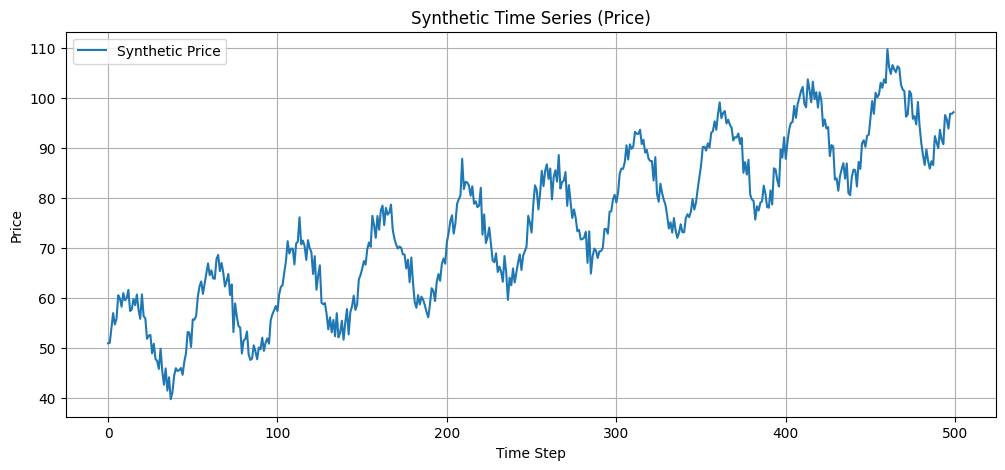

In [2]:
np.random.seed(42)
days = 500
trend = np.linspace(50, 100, days)
seasonal = 10 * np.sin(np.linspace(0, 20 * np.pi, days))
noise = np.random.normal(0, 2, days)

price = trend + seasonal + noise

plt.figure(figsize=(12, 5))
plt.plot(price, label="Synthetic Price")
plt.title("Synthetic Time Series (Price)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


# Скейлинг

In [3]:
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price.reshape(-1, 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Функція для створення послідовностей
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

window_size = 20
X, y = create_sequences(price_scaled, window_size)

# Train
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Моделі нейромереж

In [5]:
"""
Модель LSTM — спеціальний вид рекурентної нейромережі (RNN), який вміє запам’ятовувати інформацію на довгі відстані завдяки механізму "вікон пам’яті".
Це корисно при роботі з часовими рядами, де дані мають послідовну природу.

🔍 Очікування:
- Добре вловлює нелінійні залежності.
- Працює краще на стабільних серіях.
- Повільніше тренується, але дає високу точність.
"""

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [6]:
"""
MLP — це базова повнозв’язна нейромережа. Вона не враховує послідовність, але може добре працювати на "спрощених" ознаках.

🔍 Очікування:
- Висока швидкість тренування.
- Низька здатність до уловлювання складних шаблонів часу.
"""

class MLP1(nn.Module):
    def __init__(self, input_size=20):
        super(MLP1, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


In [7]:
"""
Розширений MLP з regularization через Dropout для запобігання перенавчанню.
"""

class MLP2(nn.Module):
    def __init__(self, input_size=20):
        super(MLP2, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


In [8]:
"""
XGBoost — не нейромережа, але дуже сильний базовий метод градієнтного бустінгу.
Він не враховує послідовність напряму, але може показувати чудовий результат на табличних ознаках.

🔍 Очікування:
- Висока точність на коротких вікнах.
- Швидке навчання.
- Не потребує GPU.
"""

from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
"""
CNN — зазвичай застосовується в обробці зображень, але також підходить для виявлення локальних шаблонів у часових рядах.

🔍 Очікування:
- Добре вловлює короткі шаблони.
- Менш чутлива до глобального контексту.
"""

class CNNModel(nn.Module):
    def __init__(self, input_size=20):
        super(CNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear((input_size - 4) * 16, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1))  # reshape for Conv1d
        return self.cnn(x)


# Тренування моделей

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_squared_error

# Функція для тренування PyTorch-моделі
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.001, verbose=True):
    model = model.to('cpu')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if verbose and (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    
    return model, train_losses, test_losses


# Побудова графіка "фактичні vs передбачені"

In [11]:

def plot_predictions(model, X_test, y_test, scaler, title="Prediction"):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).cpu().numpy()
        true = y_test.cpu().numpy()
    
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    
    plt.figure(figsize=(12, 5))
    plt.plot(true_inv, label='Actual')
    plt.plot(pred_inv, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Обчислення помилки RMSE

In [12]:
def evaluate_model(model, X_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).cpu().numpy()
        true = y_test.cpu().numpy()
        
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)

    rmse = root_mean_squared_error(true_inv, pred_inv)
    return rmse


# Класи моделей

In [13]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [14]:
class MLP_v2(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout=0.3):
        super(MLP_v2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], 1)
        )

    def forward(self, x):
        return self.net(x)


In [15]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM очікує вхід у вигляді (batch, seq_len, features)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # тільки останній крок


In [16]:
import xgboost as xgb

def train_xgboost(X_train_np, y_train_np, X_test_np, y_test_np, scaler):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train_np, y_train_np)
    preds = model.predict(X_test_np)

    # Зворотне масштабування
    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test_np.reshape(-1, 1))
    
    rmse = root_mean_squared_error(y_test_inv, preds_inv, squared=False)
    print(f"XGBoost RMSE: {rmse:.4f}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(preds_inv, label="Predicted")
    plt.title("XGBoost Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model


In [17]:
class CNNModel(nn.Module):
    def __init__(self, input_size, seq_len=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)  # reshape для Conv1d
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [18]:
"""
Transformer — найпотужніша модель для послідовностей, яка замінює RNN за рахунок self-attention механізму.
Вона дозволяє "дивитись" на будь-яку частину входу одразу, а не лише послідовно.

🔍 Очікування:
- Потенційно найкраща точність.
- Найважчий у навчанні (вимагає багато даних або регуляризації).
"""

class TransformerModel(nn.Module):
    def __init__(self, input_size, seq_len=20, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        self.embedding = nn.Linear(input_size, d_model)

        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model))  # (1, seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):

        x = self.embedding(x)  # -> (batch, seq_len, d_model)
        x = x + self.pos_encoder[:, :x.size(1), :]  # додати позиційне кодування (broadcast)
        x = self.transformer(x)  # -> (batch, seq_len, d_model)
        return self.fc(x[:, -1, :])  # беремо останній елемент по seq_len



In [19]:
class DLinear(nn.Module):
    def __init__(self, seq_len):
        super(DLinear, self).__init__()
        self.linear = nn.Linear(seq_len, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)


In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_tensors(model_name, X_train, y_train, X_test, y_test):
    if model_name == "MLP":
        X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.reshape(X_test.shape[0], -1), dtype=torch.float32)
    else:
        if X_train.ndim == 2:
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
        else:
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor.to(device), y_train_tensor.to(device), X_test_tensor.to(device), y_test_tensor.to(device)

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, lr=0.001):
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train).squeeze()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze().cpu().numpy()
        preds = preds.reshape(-1)
    
    y_test_np = y_test.cpu().numpy()
    return model, preds, y_test_np, train_losses

def evaluate_and_plot(model_name, preds, y_true, scaler, results_dict):
    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1))

    rmse = mean_squared_error(y_true_inv, preds_inv)
    results_dict[model_name] = rmse

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(preds_inv, label='Predicted')
    plt.title(f"{model_name} Prediction (RMSE: {rmse:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_torch_model(model_name, model, X_train, y_train, X_test, y_test, scaler, results_dict):
    print(f"🔧 Training {model_name}...")
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_tensors(
        model_name, X_train, y_train, X_test, y_test
    )

    trained_model, preds, y_true, losses = train_model(
        model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=50
    )
    
    evaluate_and_plot(model_name, preds, y_true, scaler, results_dict)

import xgboost as xgb
def run_xgboost(X_train, y_train, X_test, y_test, scaler, results_dict):
    print("🔧 Training XGBoost...")
    X_train_np = X_train.reshape(X_train.shape[0], -1)
    X_test_np = X_test.reshape(X_test.shape[0], -1)

    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train_np, y_train)
    
    preds = model.predict(X_test_np)
    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = mean_squared_error(y_test_inv, preds_inv)
    results_dict["XGBoost"] = rmse

    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(preds_inv, label="Predicted")
    plt.title(f"XGBoost Prediction (RMSE: {rmse:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()


# Генерація результатів

🔧 Training MLP...


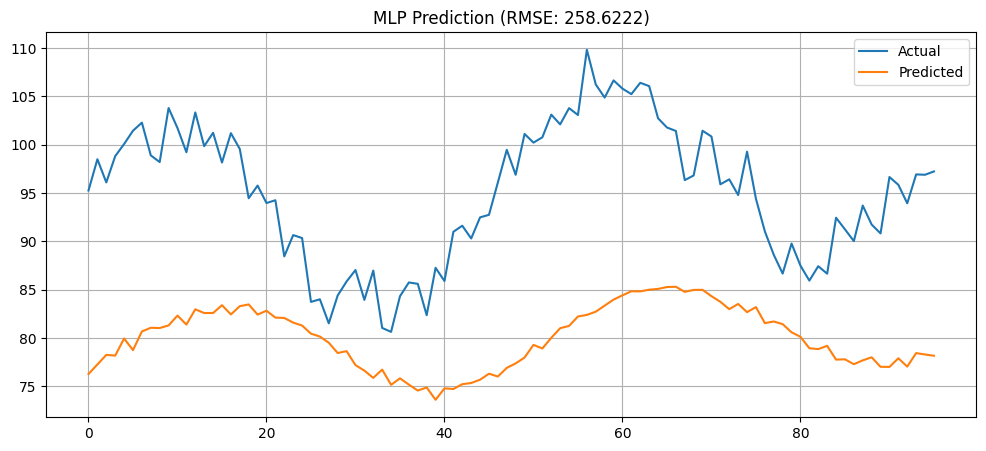

🔧 Training LSTM...


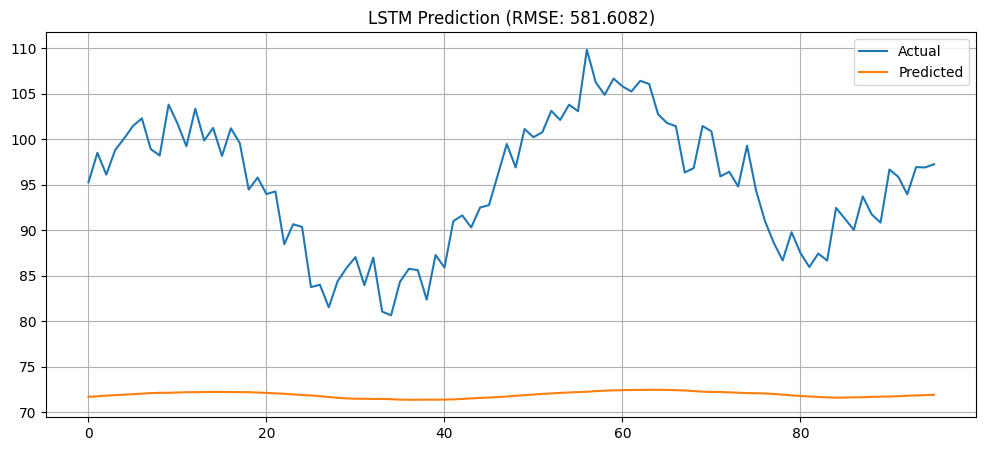

🔧 Training CNN...


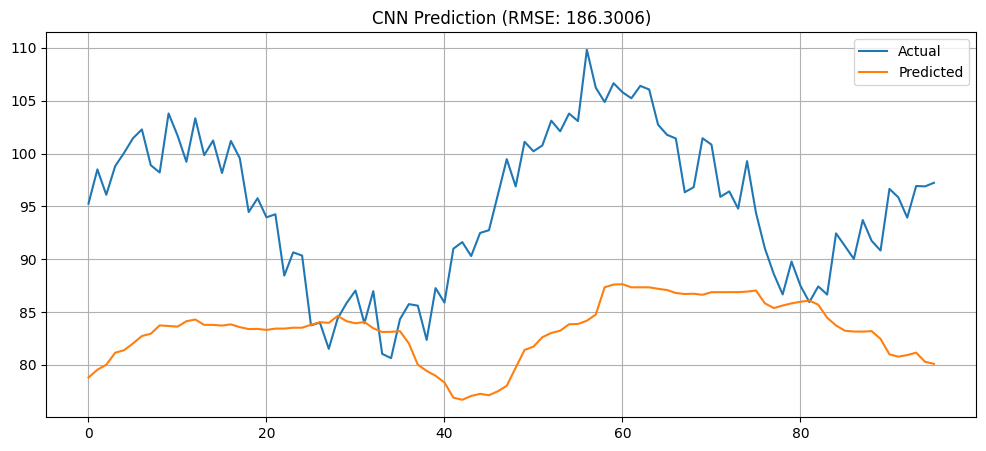

🔧 Training Transformer...


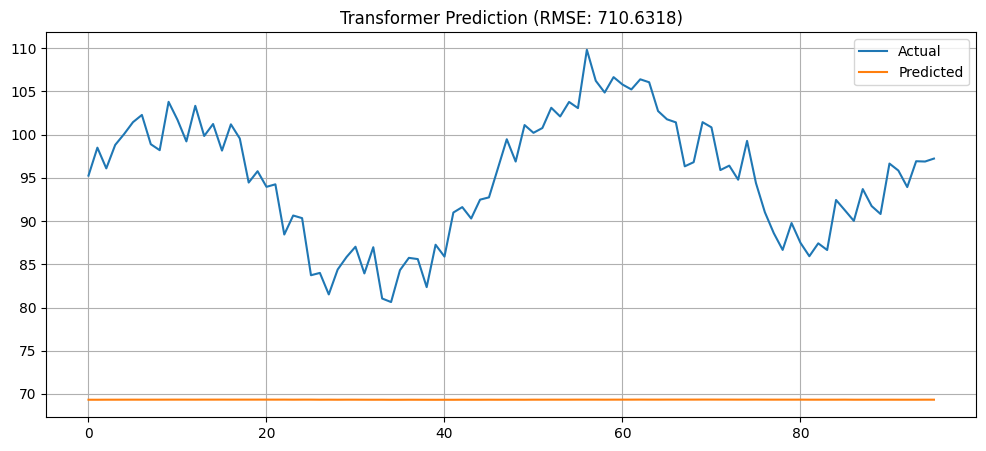

🔧 Training DLinear...


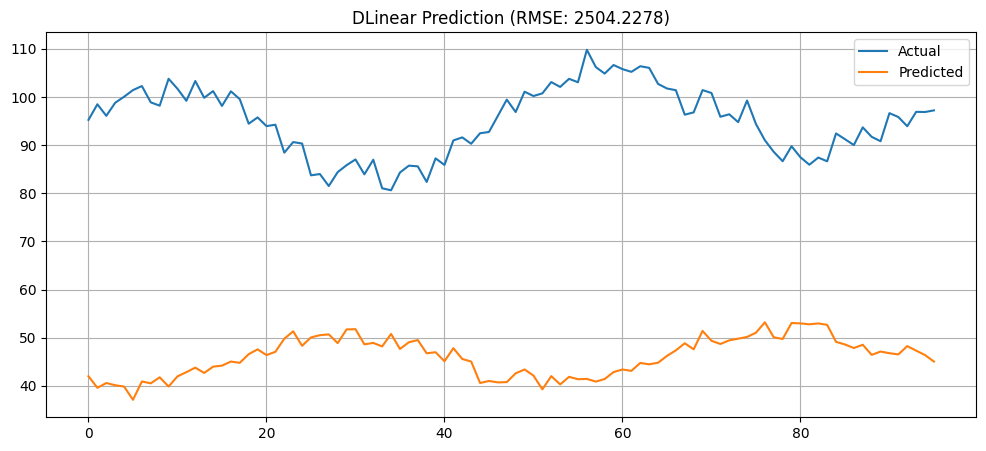

🔧 Training XGBoost...


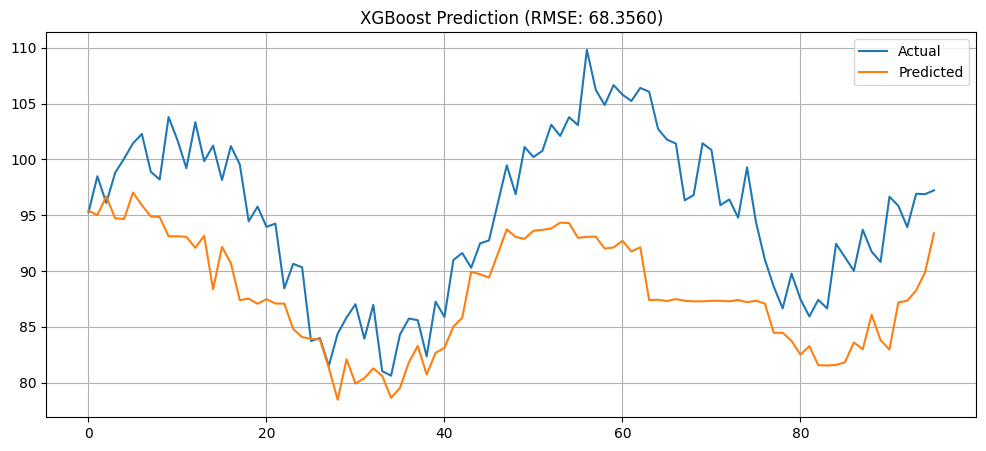


📈 RMSE Results Summary:
MLP                 : RMSE = 258.6222
LSTM                : RMSE = 581.6082
CNN                 : RMSE = 186.3006
Transformer         : RMSE = 710.6318
DLinear             : RMSE = 2504.2278
XGBoost             : RMSE = 68.3560


In [21]:
results = {}

run_torch_model("MLP", MLPModel(input_size=20, hidden_size=64), X_train, y_train, X_test, y_test, scaler, results)
run_torch_model("LSTM", LSTMModel(input_size=1), X_train, y_train, X_test, y_test, scaler, results)
run_torch_model("CNN", CNNModel(input_size=1), X_train, y_train, X_test, y_test, scaler, results)
run_torch_model("Transformer", TransformerModel(input_size=1, seq_len=X_train.shape[1]), X_train, y_train, X_test, y_test, scaler, results)
run_torch_model("DLinear", DLinear(seq_len=X_train.shape[1]), X_train, y_train, X_test, y_test, scaler, results)
run_xgboost(X_train, y_train, X_test, y_test, scaler, results)

print("\n📈 RMSE Results Summary:")
for model_name, rmse in results.items():
    print(f"{model_name:20s}: RMSE = {rmse:.4f}")


In [34]:
data_sets = []

folder_path = "../House_Prices"
files = os.listdir(folder_path)
print(files)

['California_House.csv', 'Mix_House.csv', 'Sydney_House.csv']
